### 0 Импорты и гиперпараметры

In [5]:
import re, random, numpy as np, pandas as pd
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader

from datasets import load_dataset
import gensim.downloader as api

import matplotlib.pyplot as plt, seaborn as sns
from tqdm.auto import tqdm

In [ ]:
SEED = 42
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 128
EMB_DIM = 100
HIDDEN_DIM = 128
N_EPOCHS = 5

DROPOUT_LIST = [0.2, 0.4, 0.6]
T_SAMPLES = 1000

### 1 Данные

In [7]:
dataset = load_dataset("dair-ai/emotion")
train_ds, val_ds, test_ds = dataset["train"], dataset["validation"], dataset["test"]

N_CLASSES   = train_ds.features["label"].num_classes
LABEL_NAMES = train_ds.features["label"].names

### 2 Токенизация и словарь

In [8]:
def tokenize(text):
    # простейшая regex-токенизация
    return re.findall(r"\b\w+\b", text.lower())

# 3-A. Строим частотный словарь
freq = {}
for ex in train_ds:
    for tok in tokenize(ex["text"]):
        freq[tok] = freq.get(tok, 0) + 1

# 3-B. Ограничим словарь top-50 000 (можно поменять)
MAX_VOCAB = 50_000
specials = ["<pad>", "<unk>"]
itos = specials + sorted(freq, key=freq.get, reverse=True)[:MAX_VOCAB-len(specials)]
stoi = {tok: idx for idx, tok in enumerate(itos)}
PAD_IDX, UNK_IDX = stoi["<pad>"], stoi["<unk>"]

def numericalize(text):
    return [stoi.get(tok, UNK_IDX) for tok in tokenize(text)]

### 3 Embeding слой

In [12]:
glove = api.load("glove-wiki-gigaword-100")

embedding_matrix = np.random.normal(scale=0.6, size=(len(itos), EMB_DIM))
for word, idx in stoi.items():
    if word in glove:
        embedding_matrix[idx] = glove[word]

embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)

### 4 Dataloader

In [13]:
def collate_batch(batch):
    tokens, labels, lengths = [], [], []
    for ex in batch:
        ids = torch.tensor(numericalize(ex["text"]), dtype=torch.long)
        tokens.append(ids)
        labels.append(ex["label"])
        lengths.append(len(ids))
    labels  = torch.tensor(labels, dtype=torch.long)
    lengths = torch.tensor(lengths, dtype=torch.long)
    tokens  = nn.utils.rnn.pad_sequence(tokens, padding_value=PAD_IDX)
    return tokens.t(), lengths, labels

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          collate_fn=collate_batch)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          collate_fn=collate_batch)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False,
                          collate_fn=collate_batch)

### 5 Модель

In [20]:
class TextClassifier(nn.Module):
    def __init__(self, dropout_p):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(
            embedding_matrix, freeze=False, padding_idx=PAD_IDX
        )
        self.lstm = nn.LSTM(EMB_DIM, HIDDEN_DIM,
                            batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout_p)
        self.fc = nn.Linear(HIDDEN_DIM*2, N_CLASSES)

    def forward(self, x, lengths):
        emb = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(
            emb, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        _, (h_n, _) = self.lstm(packed)
        h = torch.cat((h_n[-2], h_n[-1]), dim=1)
        h = self.dropout(h)
        return self.fc(h)

### 6 Тренировка и валидация

In [21]:
def train_epoch(model, loader, opt, crit):
    model.train()
    loss_sum, correct, total = 0, 0, 0
    for x,lens,y in loader:
        x,lens,y = x.to(DEVICE), lens.to(DEVICE), y.to(DEVICE)
        opt.zero_grad()
        out = model(x,lens)
        loss = crit(out,y)
        loss.backward(); opt.step()

        loss_sum += loss.item()*y.size(0)
        correct += (out.argmax(1)==y).sum().item()
        total += y.size(0)
    return loss_sum/total, correct/total


@torch.inference_mode()
def evaluate(model, loader, crit):
    model.eval()
    loss_sum, correct, total = 0, 0, 0
    for x,lens,y in loader:
        x,lens,y = x.to(DEVICE), lens.to(DEVICE), y.to(DEVICE)
        out = model(x,lens)
        loss_sum += crit(out,y).item()*y.size(0)
        correct += (out.argmax(1)==y).sum().item()
        total += y.size(0)
    return loss_sum/total, correct/total

In [22]:
def train_model(p):
    model = TextClassifier(p).to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    crit = nn.CrossEntropyLoss()

    for epoch in range(1, N_EPOCHS+1):
        tr_loss,tr_acc = train_epoch(model, train_loader, opt, crit)
        val_loss,val_acc = evaluate(model, val_loader, crit)
        print(f"[p={p}] Ep{epoch}/{N_EPOCHS}: "
              f"train {tr_acc:.3f} | val {val_acc:.3f}")
    return model

In [26]:
baseline_acc = {}

for p in DROPOUT_LIST:
    model = train_model(p)
    _, acc = evaluate(model, test_loader, nn.CrossEntropyLoss())
    baseline_acc[p] = acc
    print('-' * 40)
print("Baseline accuracy:", baseline_acc)

[p=0.2] Ep1/5: train 0.452 | val 0.573
[p=0.2] Ep2/5: train 0.702 | val 0.820
[p=0.2] Ep3/5: train 0.875 | val 0.884
[p=0.2] Ep4/5: train 0.923 | val 0.920
[p=0.2] Ep5/5: train 0.945 | val 0.910
----------------------------------------
[p=0.4] Ep1/5: train 0.455 | val 0.561
[p=0.4] Ep2/5: train 0.669 | val 0.775
[p=0.4] Ep3/5: train 0.861 | val 0.884
[p=0.4] Ep4/5: train 0.921 | val 0.898
[p=0.4] Ep5/5: train 0.943 | val 0.918
----------------------------------------
[p=0.6] Ep1/5: train 0.430 | val 0.540
[p=0.6] Ep2/5: train 0.622 | val 0.729
[p=0.6] Ep3/5: train 0.825 | val 0.871
[p=0.6] Ep4/5: train 0.910 | val 0.903
[p=0.6] Ep5/5: train 0.936 | val 0.911
----------------------------------------
Baseline accuracy: {0.2: 0.903, 0.4: 0.911, 0.6: 0.917}


### 7 MC-Dropout: прогноз с T прогонами

In [28]:
@torch.inference_mode()
def mc_predict(model, loader, T=T_SAMPLES):
    model.train()
    runs = []
    for _ in tqdm(range(T), leave=False, desc="MC"):
        probs = []
        for x,lens,_ in loader:
            x,lens = x.to(DEVICE), lens.to(DEVICE)
            probs.append(torch.softmax(model(x,lens), dim=1).cpu())
        runs.append(torch.cat(probs))
    runs = torch.stack(runs)
    return runs.mean(0), runs.var(0), runs

In [29]:
def eval_mc(model, loader):
    mean, var, runs = mc_predict(model, loader)
    y_true = torch.tensor([ex["label"] for ex in test_ds])
    y_pred = mean.argmax(1)
    acc = (y_pred==y_true).float().mean().item()

    sigma_max = var[torch.arange(len(y_pred)), y_pred].numpy()
    return acc, sigma_max, runs

mc_acc, mc_sigma = {}, {}
for p in DROPOUT_LIST:
    print(f"\n=== MC-Dropout p={p} ===")
    model = train_model(p)
    acc, sig, _ = eval_mc(model, test_loader)
    mc_acc[p] = acc
    mc_sigma[p] = sig
print("MC accuracy:", mc_acc)



=== MC-Dropout p=0.2 ===
[p=0.2] Ep1/5: train 0.456 | val 0.607
[p=0.2] Ep2/5: train 0.725 | val 0.831
[p=0.2] Ep3/5: train 0.885 | val 0.896
[p=0.2] Ep4/5: train 0.926 | val 0.916
[p=0.2] Ep5/5: train 0.946 | val 0.924


MC:   0%|          | 0/1000 [00:00<?, ?it/s]


=== MC-Dropout p=0.4 ===
[p=0.4] Ep1/5: train 0.452 | val 0.557
[p=0.4] Ep2/5: train 0.684 | val 0.797
[p=0.4] Ep3/5: train 0.873 | val 0.890
[p=0.4] Ep4/5: train 0.929 | val 0.912
[p=0.4] Ep5/5: train 0.946 | val 0.922


MC:   0%|          | 0/1000 [00:00<?, ?it/s]


=== MC-Dropout p=0.6 ===
[p=0.6] Ep1/5: train 0.447 | val 0.551
[p=0.6] Ep2/5: train 0.648 | val 0.774
[p=0.6] Ep3/5: train 0.847 | val 0.892
[p=0.6] Ep4/5: train 0.913 | val 0.904
[p=0.6] Ep5/5: train 0.940 | val 0.910


MC:   0%|          | 0/1000 [00:00<?, ?it/s]

MC accuracy: {0.2: 0.9154999852180481, 0.4: 0.9120000004768372, 0.6: 0.9039999842643738}


### 8 Визуализация

<Figure size 640x480 with 0 Axes>

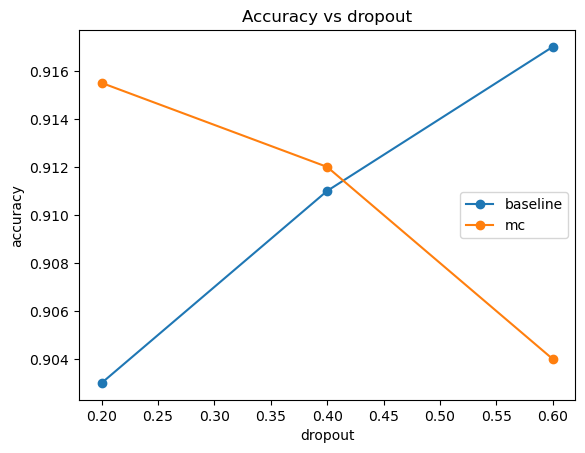

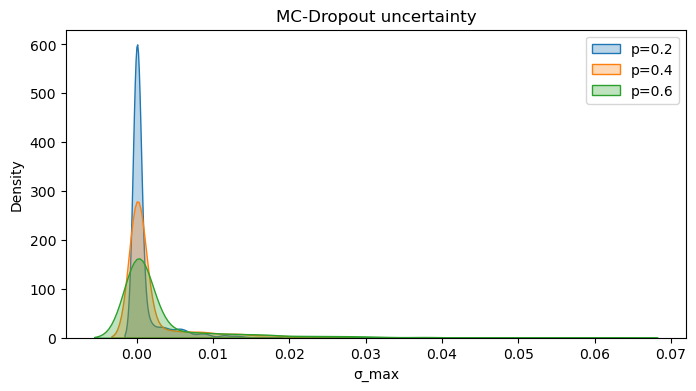

In [30]:
plt.figure()
pd.DataFrame({
    "dropout": DROPOUT_LIST,
    "baseline": [baseline_acc[p] for p in DROPOUT_LIST],
    "mc": [mc_acc[p] for p in DROPOUT_LIST]
}).set_index("dropout").plot(marker="o")
plt.ylabel("accuracy");
plt.title("Accuracy vs dropout");
plt.show()

plt.figure(figsize=(8,4))
for p,s in mc_sigma.items():
    sns.kdeplot(s, label=f"p={p}", fill=True, alpha=0.3)
plt.xlabel("σ_max"); plt.title("MC-Dropout uncertainty")
plt.legend()
plt.show()

[p=0.4] Ep1/5: train 0.454 | val 0.555
[p=0.4] Ep2/5: train 0.650 | val 0.761
[p=0.4] Ep3/5: train 0.842 | val 0.881
[p=0.4] Ep4/5: train 0.914 | val 0.913
[p=0.4] Ep5/5: train 0.940 | val 0.913


MC:   0%|          | 0/500 [00:00<?, ?it/s]

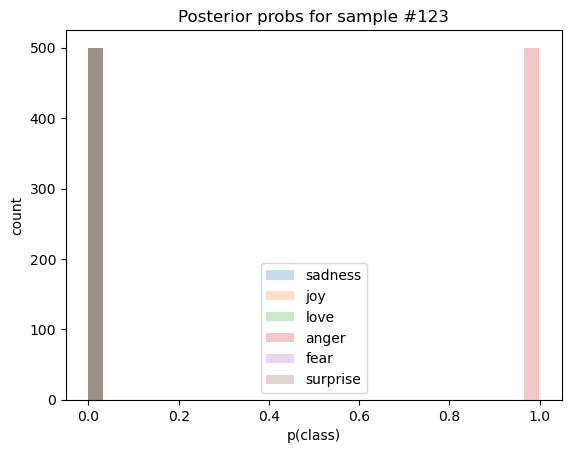

In [32]:
def plot_posterior(runs, sample_id=0):
    T, N, C = runs.shape
    df = pd.DataFrame(runs[:,sample_id,:].numpy(), columns=LABEL_NAMES)
    df.plot(kind="hist", alpha=0.25, bins=30)
    plt.title(f"Posterior probs for sample #{sample_id}")
    plt.xlabel("p(class)"); plt.ylabel("count"); plt.show()

p_demo = 0.4
model = train_model(p_demo)
_, _, runs_demo = mc_predict(model, test_loader, T=500)
plot_posterior(runs_demo, sample_id=123)

### 9 Выводы

1. Чем выше p, тем выше дисперсия (модель осторожнее), но слишком большой p снижает accuracy.

2. σ_max хорошо разделяет «уверенные vs сомнительные» предсказания.